# Simulation plots

In [2]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [308]:
#IMPORTANT: which_host is always a array index (0,1,2), 
#_i is always index from the catalogue, 
#and _ids is id from the catalogue
class SimTools():
    def __init__(self, catalogue, snapshot, membership_file, siminfo_file, volume_num):
        self.catalogue_file = catalogue
        self.snapshot = snapshot
        self.membership_file = membership_file
        self.siminfo_file = siminfo_file
        self.mstar = None
        self.mtotal = None
        self.soap = h5py.File(self.catalogue_file, 'r') # Read in SOAP property file
        self.field = np.array(self.soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
        self.vol = volume_num
        self.halo_ids = self.soap['VR/ID']
        self.host_halo_ids = np.array(self.soap['VR/ID'])[self.field==-1]
        self.host_halo_i = np.array(self.host_halo_ids)-1
        
        with open(self.siminfo_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if 'h_val' in line:
                parts = line.split()
                self.h_val = float(parts[2])
                break
        
    def getHaloMasses(self):
        self.mtotal = np.array(self.soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
        self.mstar = np.array(self.soap['ExclusiveSphere/30kpc/StellarMass'])

        return self.mtotal, self.mstar

    def getHaloDarkMatterMembers(self, halo_i):
        #halo INDEX is not halo ID
        # function to read in bound DM particles for a given halo
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.positions

    def getHaloStarsMembers(self, halo_i):
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.star_positions
    
    def calc_r200(self, host_i):
        m200 = np.array(self.soap['SO/200_crit/TotalMass'])[host_i] #mass is in solar mass
        
        H = self.h_val*100 #converting from H/100 to h
        G = 4.3e-9 #converting from pc to Mpc
        rho_crit = 3*(H**2)/(8*np.pi*G)
        r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
        return r200
            
    def make_volume_table(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        host_r200 = [self.calc_r200(i) for i in range(len(self.host_halo_i))]
        host_CoM = np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])[self.host_halo_i]
        host_tot_mass = [self.mtotal[i] for i in self.host_halo_i]
        host_stellar_mass = [self.mstar[i] for i in self.host_halo_i]
        sat_ids = [np.array(self.halo_ids[self.field==i]) for i in self.host_halo_ids]
        sat_i = [ids-1 for ids in sat_ids]
        sat_CoM = []
        sat_tot_mass = []
        sat_stellar_mass = []
        for i in sat_i:
            sat_CoM.append(np.array(self.soap['BoundSubhaloProperties/CentreOfMass'])[i])
            sat_tot_mass.append(self.mtotal[i])
            sat_stellar_mass.append(self.mstar[i])
        #sat_CoM = np.array(sat_CoM)
        #sat_tot_mass = np.array(sat_tot_mass)
        #sat_stellar_mass = np.array(sat_stellar_mass)
        vol = np.full(len(self.host_halo_i), self.vol)

        data_array = [vol, self.host_halo_i, self.host_halo_ids, host_r200, 
                      host_CoM, host_tot_mass, host_stellar_mass, 
                      sat_ids, sat_i, sat_CoM,
                      sat_tot_mass, sat_stellar_mass]
        col_labels = ['Volume', 'Host i', 'Host ID', 'Host R200', 
                      'Host CoM', 'Host Mtot', 'Host M*', 
                      'Sat i', 'Sat ID', 'Sat CoM', 'Sat Mtot', 'Sat M*']
        df = pd.DataFrame(data = data_array)#, columns = col_labels)
        self.main_df = df.transpose()
        self.main_df.columns = col_labels
        return self.main_df
    
    def getCentralHalos(self, mass_cut=True):
        #have to edit once data table is done
        center = np.array([float(c) for c in centers.loc[15]])     
        
        #get massive host halos
        central_df = self.main_df.loc[(self.main_df['Host M*']>1e9)]
        #get halos within 5Mpc of volume center and 
        distance_mask = []
        for i in range(len(central_df)):
            val = all(np.abs(central_df['Host CoM'].iloc[i]-center) < 5)
            distance_mask.append(val)

        self.central_df = central_df.loc[distance_mask]

        #do mass cut of all satellite halos if mass_cut=True
        if mass_cut==True:
            mstar_mask = [self.central_df['Sat M*'].iloc[i]>1e5 for i in range(len(self.central_df))]
            for col in self.central_df.iloc[0, 7:].keys():
                for i in range(len(mstar_mask)):
                    self.central_df[col].iloc[i] = self.central_df[col].iloc[i][mstar_mask[i]]

            mtot_mask = [self.central_df['Sat Mtot'].iloc[i]>10**7.5 for i in range(len(self.central_df))]
            for col in self.central_df.iloc[0, 7:].keys():
                for i in range(len(mtot_mask)):
                    self.central_df[col].iloc[i] = self.central_df[col].iloc[i][mtot_mask[i]]

        return self.central_df
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.mtotal[self.field==-1])))
        axs[1].hist(np.log10(np.ma.array(self.mstar[self.field==-1])))
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'r','--')
        fig.suptitle('Field Halo mass distributions')
        fig.show()
    
    def plotBoxParticleDistribution(self):
        data = sw.load(self.snapshot) #read final snapshot
        pos = data.dark_matter.coordinates
        plt.figure(dpi=200)
        plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
        side_length = 0.20
        center_x = 381.5
        center_y = 160
        # Calculate the bottom left corner of the square
        bottom_left_x = center_x - side_length / 2
        bottom_left_y = center_y - side_length / 2

        # Square box around the center
        #square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')
        #plt.gca().add_patch(square_box)
        plt.show()

    def plot_particles(self, host_i):
        host_halo_part = self.getHaloDarkMatterMembers(host_i)
        host_star_part = self.getHaloStarsMembers(host_i)
        sat_halo_part = []
        sat_star_part = []
        for i in self.central_df.loc[host_i]['Sat i']:
            sat_halo_part.append(self.getHaloDarkMatterMembers(i))
            sat_star_part.append(self.getHaloStarsMembers(i))    
        
        fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
        ax[0].scatter(host_halo_part[:,1], host_halo_part[:,2], s=1, alpha = 0.2, c='black')
        ax[1].scatter(host_star_part[:,1], host_star_part[:,2], s=1, alpha = 0.2, c='black')
        for sat in sat_halo_part:
            ax[0].scatter(sat[:][1], sat[:][2], s=1, alpha=0.2, c='red')
        for sat in sat_star_part:
            ax[1].scatter(sat[:][1], sat[:][2], s=1, alpha=0.2, c='red')
        ax[1].set_title(f'Star particles of halo {host_i+1} and satellites')
        ax[0].set_title(f'Dark matter particles of halo {host_i+1} and satellites')
        fig.show()
    
    def number_plots(self, distance_cut=True):        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        
        for i in range(len(self.central_df)):
            r200 = self.central_df['Host R200'].iloc[i]
            host_center = self.central_df['Host CoM'].iloc[i]
            satellite_centers = self.central_df['Sat CoM'].iloc[i]
            distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000

            if distance_cut==True:
                # Distance cut of satellites
                distance_mask = distances < r200
                distances = distances[distance_mask]
                sat_mstar = self.central_df['Sat M*'].iloc[i][distance_mask]
                sat_mtot = self.central_df['Sat Mtot'].iloc[i][distance_mask]
            else:
                sat_mstar = self.central_df['Sat M*'].iloc[i]
                sat_mtot = self.central_df['Sat Mtot'].iloc[i]

            arrays = {
                'distance': distances,
                'distance_norm': distances / r200,
                'mstar': sat_mstar, 
                'mtotal': sat_mtot, 
                'mstar_norm': sat_mstar / self.central_df.iloc[i]['Host M*'], 
                'mtotal_norm': sat_mtot / self.central_df.iloc[i]['Host Mtot']
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for j, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'distance' or key == 'distance_norm':
                    y_values = np.linspace(len(x_values) + 1, 1, len(x_values))
                else:
                    ax_flat[j].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)

                # Plot the values with a label for the host index
                host_id = self.central_df.iloc[i]['Host ID']
                ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel('$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle('Central halo satellite properties')

        plt.show()


In [309]:
#SOAP_fname = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5'
#SOAP_membership = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_membership_0063.hdf5'
#snapshot = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5'
#siminfo_file = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/halo_0063.siminfo'
SOAP_fname = 'data/SOAP_halo_properties_0063.hdf5'
SOAP_membership = 'data/SOAP_membership_0063.hdf5'
snapshot = 'data/snapshot_0063.hdf5'
siminfo_file = 'data/halo_0063.siminfo'

vol15_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, 15)
vol15_main_df = vol15_sim.make_volume_table()
vol15_df = vol15_sim.getCentralHalos(mass_cut=True)
#vol15_sim.plotStellarMassHaloMass_all()
#vol15_sim.plotFieldHaloMassDist()
#vol15_sim.plotBoxParticleDistribution()

C:\Users\prera\AppData\Local\Temp\ipykernel_19272\3407528325.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].iloc[i] = self.central_df[col].iloc[i][mstar_mask[i]]
C:\Users\prera\AppData\Local\Temp\ipykernel_19272\3407528325.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].iloc[i] = self.central_df[col].iloc[i][mtot_mask[i]]


In [319]:
host_i=3
host_halo_part = vol15_sim.getHaloDarkMatterMembers(host_i)
host_star_part = vol15_sim.getHaloStarsMembers(host_i)
sat_halo_part = []
sat_star_part = []
for i in vol15_main_df.loc[host_i]['Sat i']:
    sat_halo_part.append(vol15_sim.getHaloDarkMatterMembers(i-1))
    sat_star_part.append(vol15_sim.getHaloStarsMembers(i-1))    

19


C:\Users\prera\AppData\Local\Temp\ipykernel_19272\3500167313.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


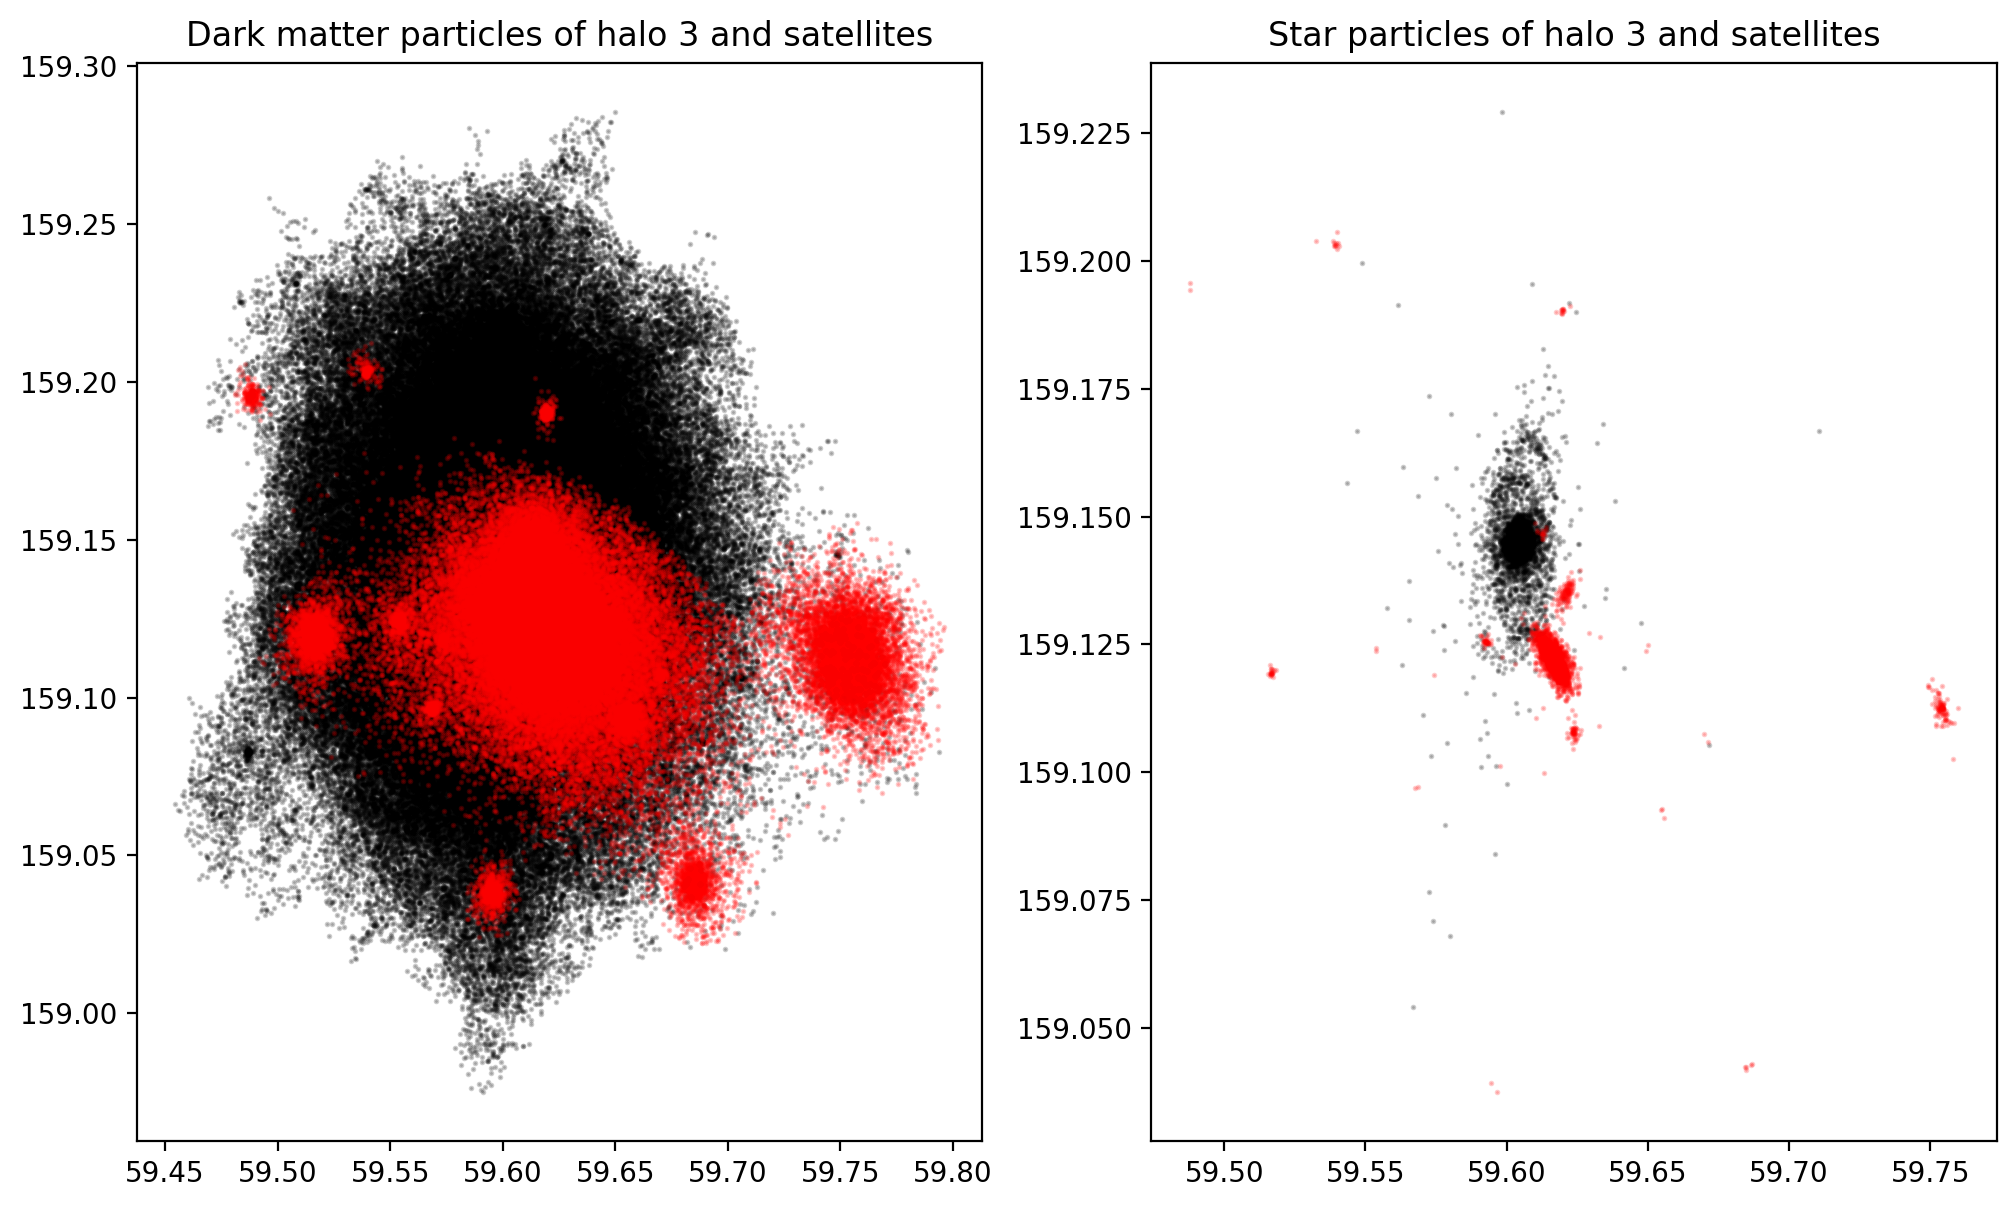

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
ax[0].scatter(host_halo_part[:,1], host_halo_part[:,2], s=1, alpha = 0.2, c='black')
ax[1].scatter(host_star_part[:,1], host_star_part[:,2], s=1, alpha = 0.2, c='black')
for sat in sat_halo_part:
    ax[0].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
for sat in sat_star_part:
    ax[1].scatter(sat[:,1], sat[:,2], s=1, alpha=0.2, c='red')
ax[1].set_title(f'Star particles of halo {host_i+1} and satellites')
ax[0].set_title(f'Dark matter particles of halo {host_i+1} and satellites')
fig.show()

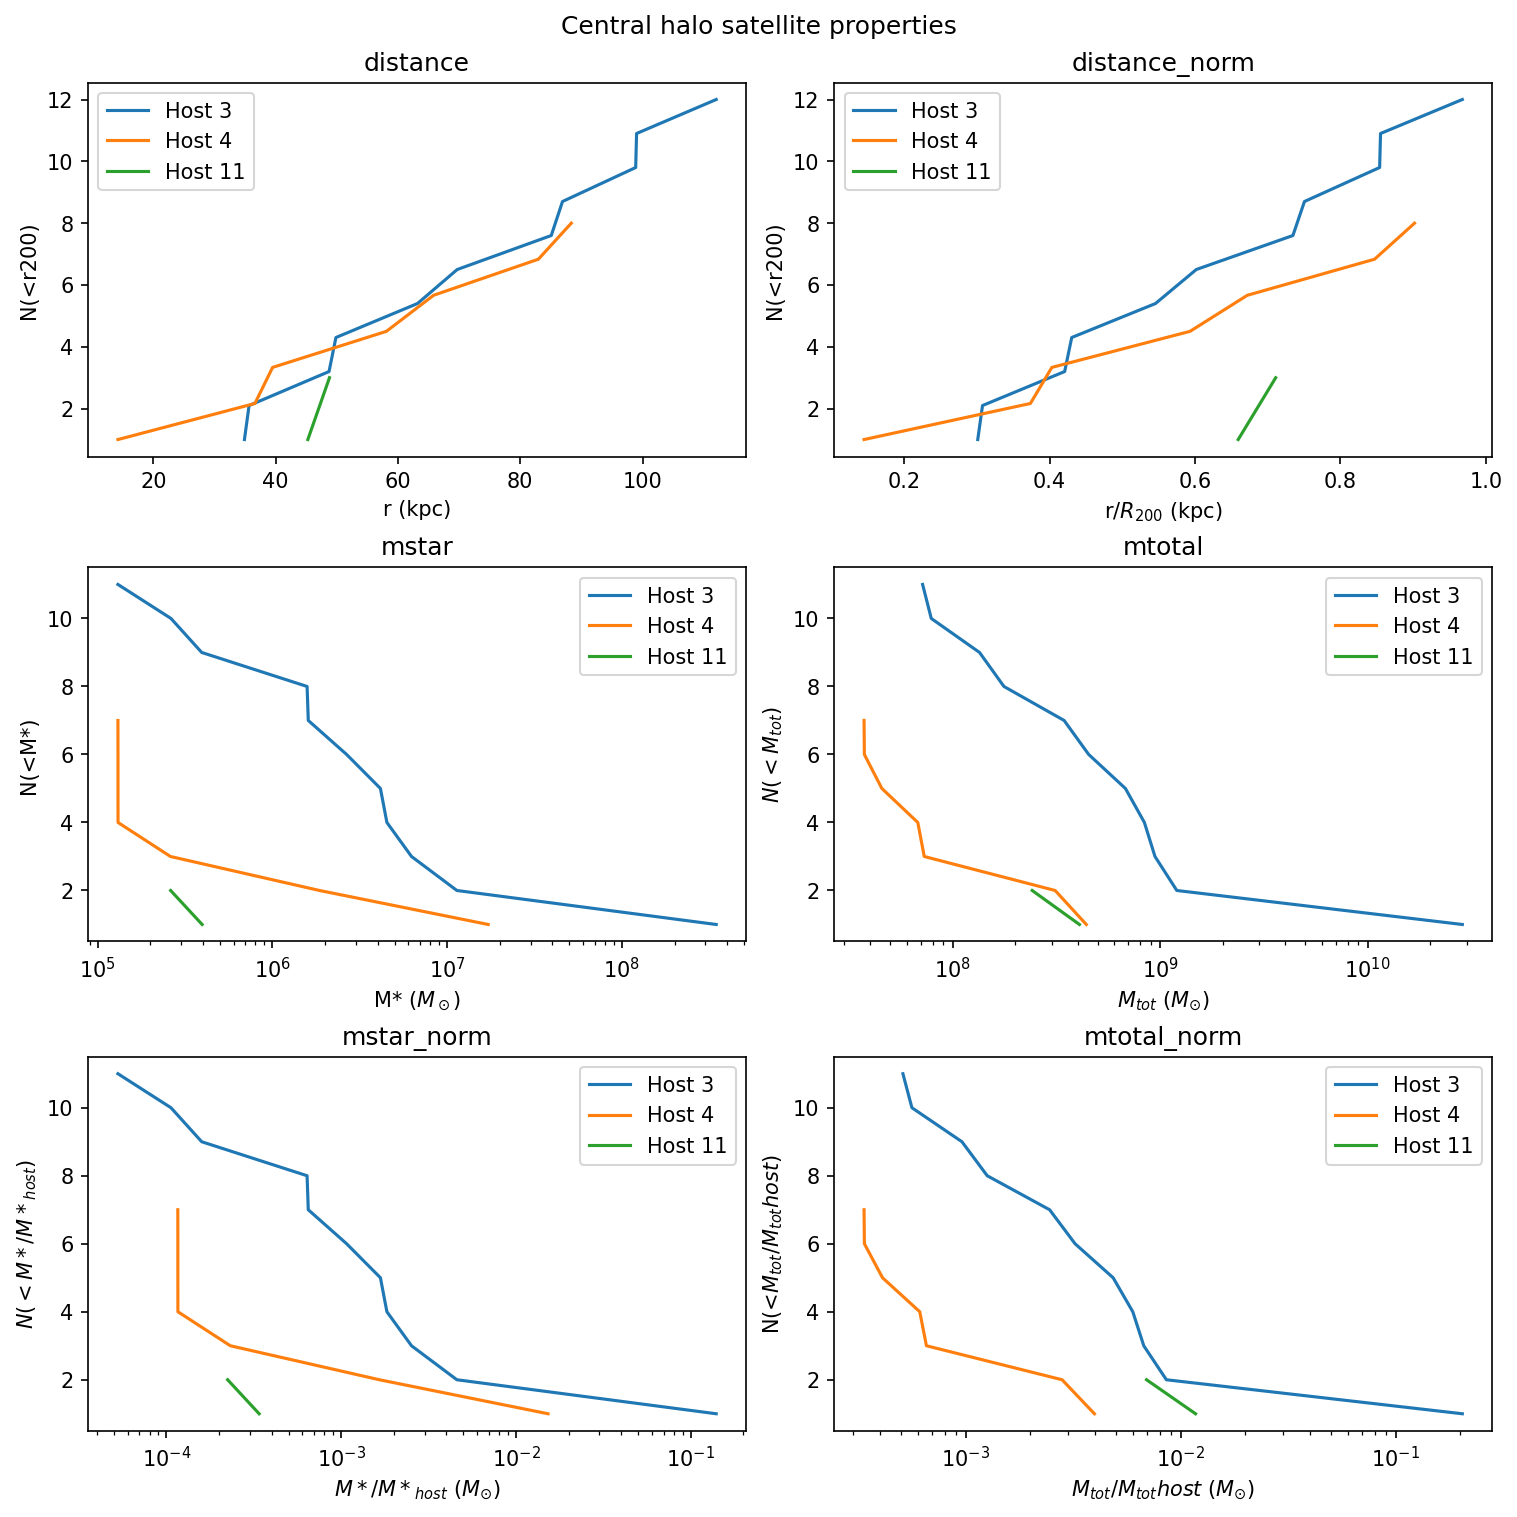

In [303]:
vol15_sim.number_plots(distance_cut=True)

[array([378.70935 ,  59.600876, 159.14276 ], dtype=float32)
 array([379.47266 ,  60.625595, 158.08665 ], dtype=float32)
 array([382.34055,  61.09489, 156.16888], dtype=float32)]


C:\Users\prera\AppData\Local\Temp\ipykernel_19272\610383075.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


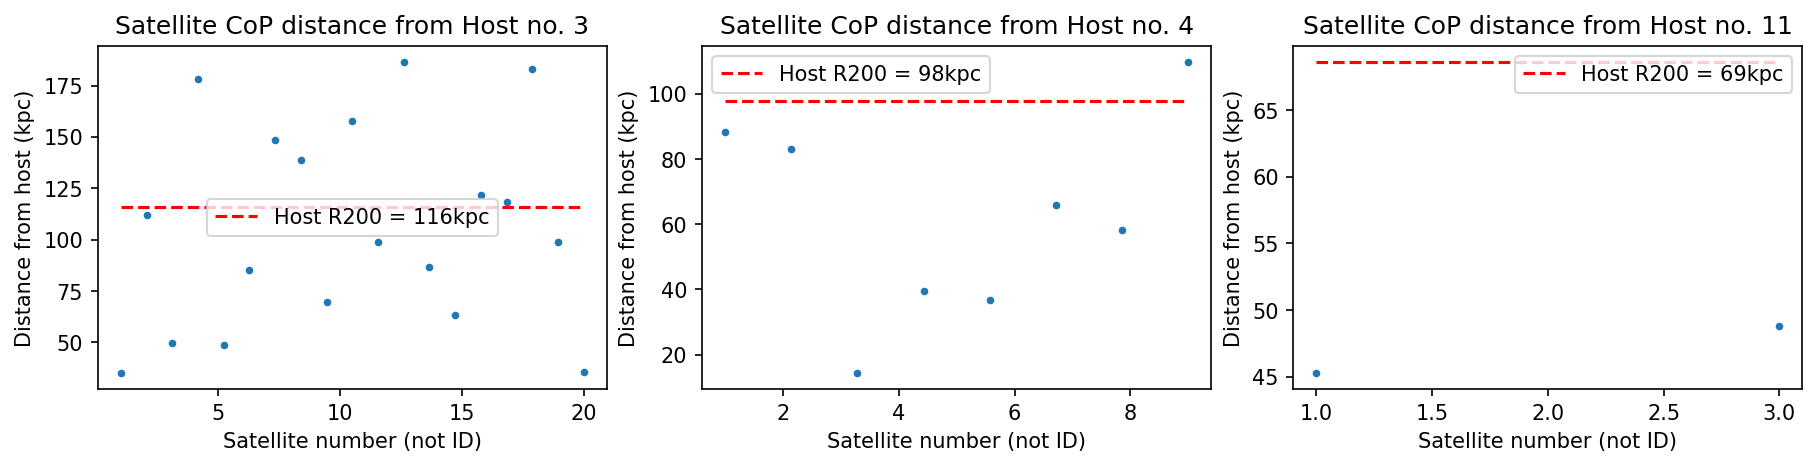

In [271]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_centers = np.array(vol15_df['Host CoM'])
print(central_centers)
for i, host_center in enumerate(central_centers):
    sat_centers = np.array(vol15_df['Sat CoM'].iloc[i])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in sat_centers])*1000 #in kpc
    x = np.linspace(1, len(distances)+1, len(distances)) 
    ax_flat[i].scatter(x, distances, s = 7)
    r200 = vol15_df['Host R200'].iloc[i]
    ax_flat[i].hlines(r200, min(x), max(x), 'r', '--', label = f'Host R200 = {r200:.0f}kpc')
    ax_flat[i].set_xlabel('Satellite number (not ID)')
    ax_flat[i].set_ylabel('Distance from host (kpc)')
    host_id = vol15_df['Host ID'].iloc[i]
    ax_flat[i].set_title(f'Satellite CoP distance from Host no. {host_id}')
    ax_flat[i].legend()
fig.show()

C:\Users\prera\AppData\Local\Temp\ipykernel_19272\3524518681.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


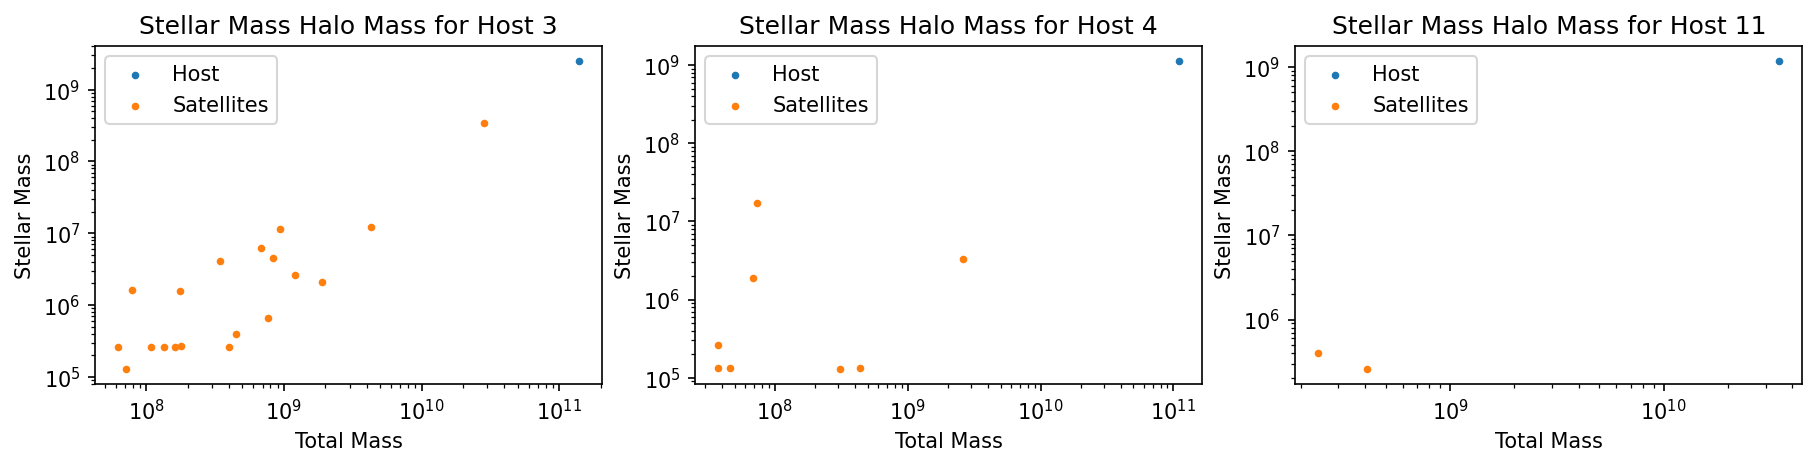

In [289]:
#make stellar mass hallo mass plots for each host and its respective satelites
fig, ax = plt.subplots(1, 3, figsize = (12, 3), dpi=150, constrained_layout=True)
for i, a in enumerate(ax):
    a.scatter(vol15_df['Host Mtot'].iloc[i], vol15_df['Host M*'].iloc[i], s=7, label='Host')
    a.scatter(vol15_df['Sat Mtot'].iloc[i], vol15_df['Sat M*'].iloc[i], s=7, label='Satellites')
    a.set_xlabel('Total Mass')
    a.set_ylabel('Stellar Mass')
    a.set_xscale('log')
    a.set_yscale('log')
    a.legend()
    host_id = vol15_df['Host ID'].iloc[i]
    a.set_title(f'Stellar Mass Halo Mass for Host {host_id}')
fig.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

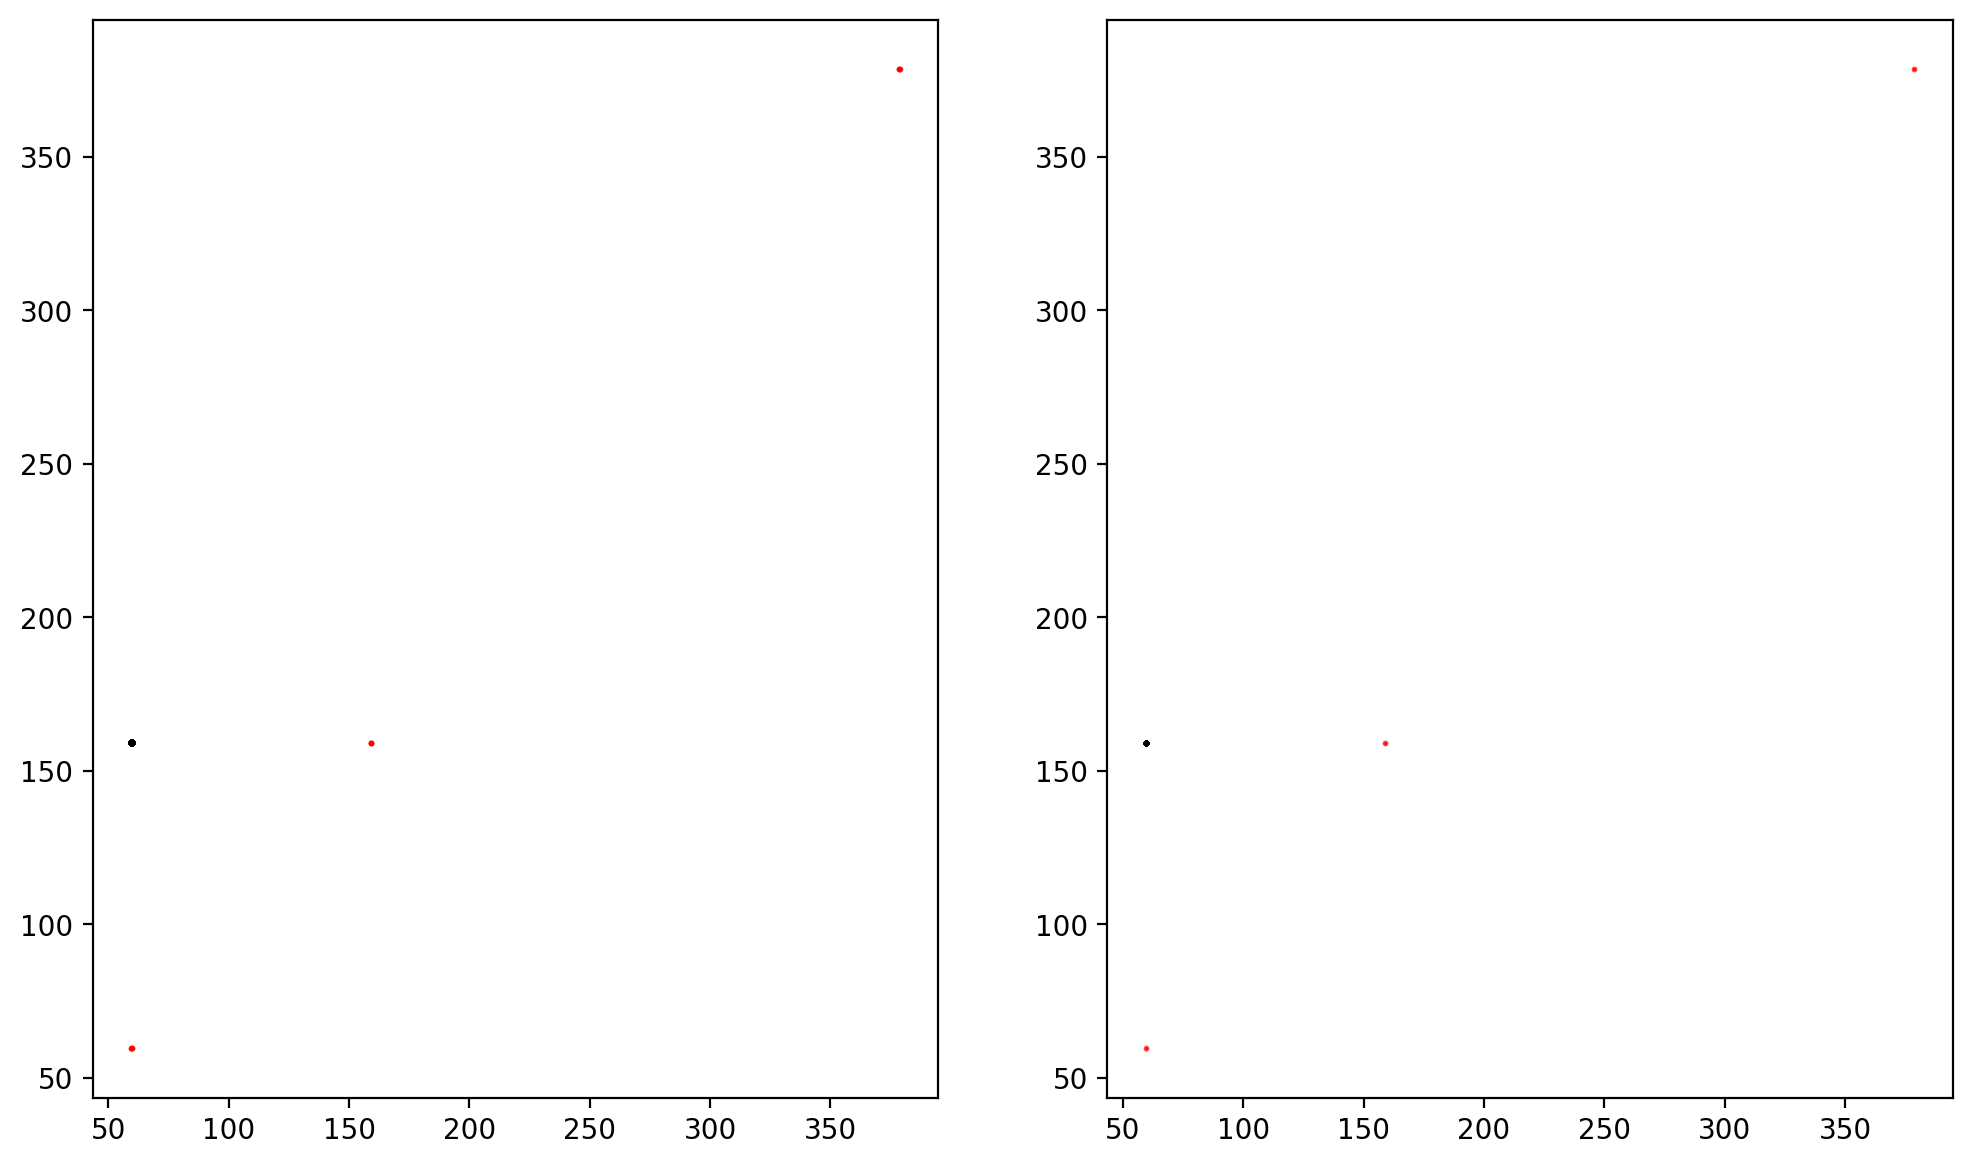

In [310]:
#vol15_sim.plot_particles(0)
#vol15_sim.plot_particles(1)
vol15_sim.plot_particles(2)